In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from joblib import parallel_backend
import shap
import pickle

from ozzy_torch_utils.subject_dataset import *

np.set_printoptions(precision=2, suppress=True)

In [72]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort"

selected_labels = ['CN', 'MCI']

# Dictionary key representing the disease labels
labels_string = 'research_group'


In [73]:
dataset = SubjectDataset(data_path, selected_labels, data_string='scores')

Csv files: ['/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort/idaSearch_3_19_2025.csv']


In [74]:
labels = np.array([dataset[index]['research_group'] for index in range(len(dataset.subject_list))])

scores = np.array([dataset[index]['scores'] for index in range(len(dataset.subject_list))])

In [97]:
with parallel_backend('threading', n_jobs=8):

    model = RandomForestClassifier(n_estimators=200, max_depth=2,  max_features='sqrt', class_weight='balanced', bootstrap=True, oob_score=True)

    cv = StratifiedKFold(n_splits=10, shuffle=True)

    auc_scores = cross_val_score(model, scores, labels, cv=cv, scoring='roc_auc')
    f1_scores = cross_val_score(model, scores, labels, cv=cv, scoring='f1')

    print(f'Cross-validation AUC scores: {auc_scores}')
    print(f'Mean cross-validation AUC score: {np.mean(auc_scores)}')
    print(f'Standard deviation of cross-validation AUC: {np.std(auc_scores)}')
    print(f'Cross-validation f1 scores: {f1_scores}')
    print(f'Mean cross-validation f1 score: {np.mean(f1_scores)}')
    print(f'Standard deviation of cross-validation f1: {np.std(f1_scores)}')


Cross-validation AUC scores: [0.86 0.9  0.84 0.88 0.85 0.83 0.86 0.84 0.85 0.92]
Mean cross-validation AUC score: 0.8637381689517912
Standard deviation of cross-validation AUC: 0.027205255168734902
Cross-validation f1 scores: [0.76 0.76 0.79 0.81 0.78 0.8  0.8  0.91 0.82 0.73]
Mean cross-validation f1 score: 0.7962403834216383
Standard deviation of cross-validation f1: 0.04501654533129287


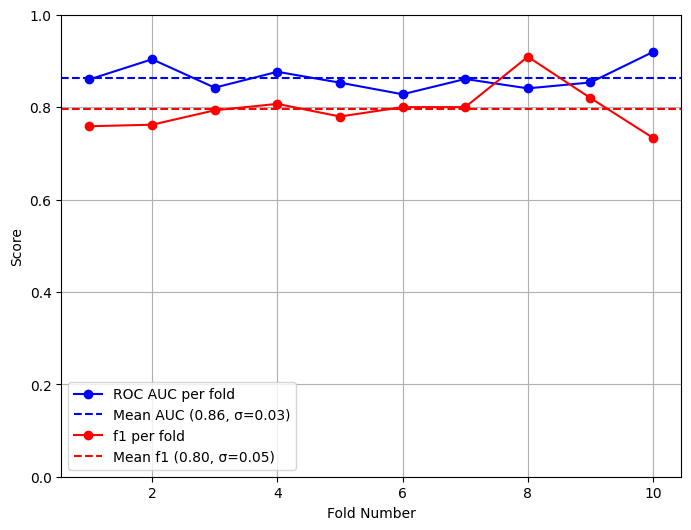

In [98]:

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(auc_scores) + 1), auc_scores, marker='o', color='b', linestyle='-', label=f'ROC AUC per fold')
plt.axhline(y=np.mean(auc_scores), color='b', linestyle='--', label=f'Mean AUC ({np.mean(auc_scores):.2f}, σ={np.std(auc_scores):.2f})')
plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='o', color='r', linestyle='-', label=f'f1 per fold')
plt.axhline(y=np.mean(f1_scores), color='r', linestyle='--', label=f'Mean f1 ({np.mean(f1_scores):.2f}, σ={np.std(f1_scores):.2f})')
plt.xlabel('Fold Number')
plt.ylabel(f'Score')
plt.ylim(0,1)
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

np.savez('/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scores_cv.npz', auc_scores=auc_scores, f1_scores=f1_scores)

In [99]:
model.fit(scores, labels)

with open(f'scores_gbdt.pkl', 'wb') as file:
    
    pickle.dump(model, file)  
